In [31]:
from scipy.optimize import nnls
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF

from random import sample

from functions import cosine_perm, simulate_mixedBIG, simulate_mixedLittle, simulate_counts
from fengetal2018 import deepNMF

## Split data
Firstly we write a method to split the mutational profile matrix into a training and validation set.

In [32]:
def split_data(data, frac_1):
  x_train = data.sample(frac = frac_1)
  x_validation = data.drop(x_train.index)
  return x_train, x_validation

# NMF performance

In [33]:
def out_errorNMF(train_df, validation_df, nsigs ,true_sigs):
  model = NMF(n_components=nsigs, init='random', max_iter = 500)
  exposures = model.fit_transform(train_df)
  signatures = model.components_
  cos_NMF = cosine_perm(true_sigs.to_numpy().T, signatures)[0]
  cos_mean = np.mean(cos_NMF.diagonal())


  ref_exposures = model.transform(X = validation_df)
  rec = np.dot(ref_exposures, signatures)
  MSE = np.mean(((validation_df - rec)**2).to_numpy())

  return([cos_mean, MSE])

# AAUtoSig performance

In [34]:
def out_error_deepNMF(train_df, validation_df, nsigs, true_sigs):
    signatures, _ = deepNMF([13, 10, nsigs], train_df)
    cos_Deep = cosine_perm(true_sigs.to_numpy().T, signatures.T)[0]
    cos_mean = np.mean(cos_Deep.diagonal())

    def calculate_exp(b):
       return(nnls(A = signatures, b = b))[0]
    ref_exposures = validation_df.apply(calculate_exp, 
                                    axis = 0) 
    rec = np.dot(ref_exposures.T, signatures.T)

    MSE = np.mean(((validation_df.T - rec)**2).to_numpy())
    return ([cos_mean, MSE])

## Performance analysis

In [ ]:
def performance_analysis(npatients, nsigs):
  mut_matrix_l, signatures_l, _ = simulate_counts(nsigs, npatients)
  train_data_l, validation_data_l = split_data(mut_matrix_l.T, 0.8)
  mut_matrix_nl, signatures_nl = simulate_mixedLittle(nsigs, npatients)
  train_data_nl, validation_data_nl = split_data(mut_matrix_nl.T, 0.8)
  mut_matrix_bnl, signatures_bnl = simulate_mixedBIG(nsigs, npatients)
  train_data_bnl, validation_data_bnl = split_data(mut_matrix_bnl.T, 0.8)
  return(out_errorNMF(train_data_l, validation_data_l, nsigs, signatures_l) + 
          out_error_deepNMF(train_data_l.T, validation_data_l.T, nsigs, signatures_l) +
          out_errorNMF(train_data_nl, validation_data_nl, nsigs, signatures_nl) + 
          out_error_deepNMF(train_data_nl.T, validation_data_nl.T, nsigs, signatures_nl) +
          out_errorNMF(train_data_bnl, validation_data_bnl, nsigs, signatures_bnl) + 
          out_error_deepNMF(train_data_bnl.T, validation_data_bnl.T, nsigs, signatures_bnl))
asd = [performance_analysis(5000, 7) for _ in range(100)] 
result = pd.DataFrame(asd)
result.columns = ["cosineNMF linear", "outNMF linear", "cosineAE linear", "outAE linear", 
                  "cosineNMF nonlinear", "outNMF nonlinear", "cosineAE nonlinear", "outAE nonlinear",
                  "cosineNMF big nonlinear", "outNMF big nonlinear", "cosineAE big nonlinear", "outAE big nonlinear"]


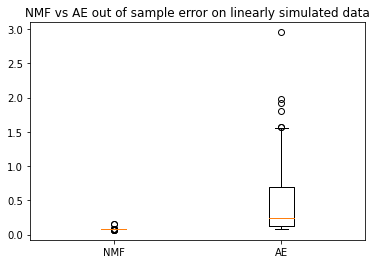

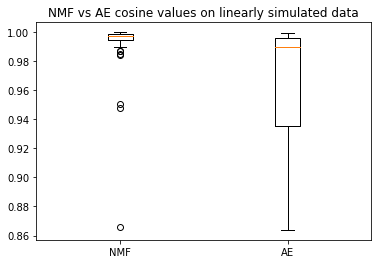

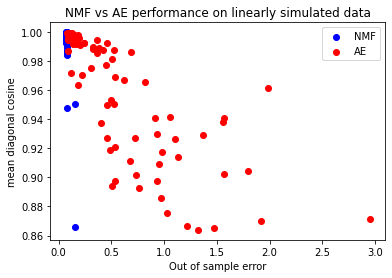

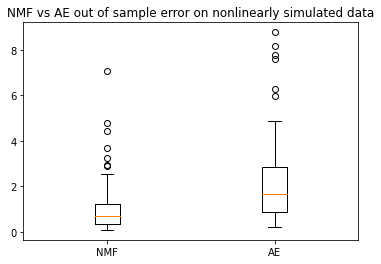

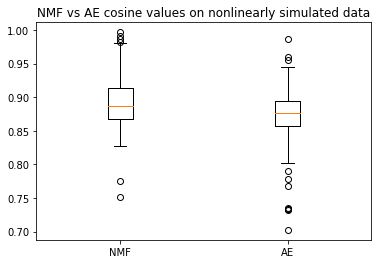

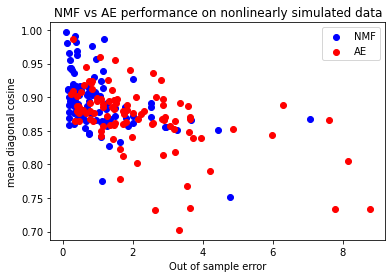

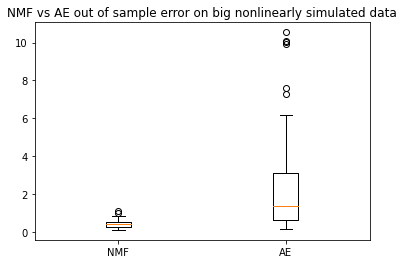

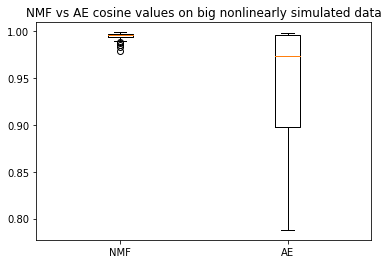

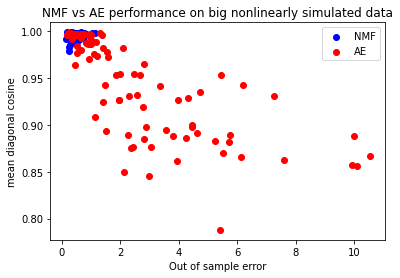

In [36]:
plt.boxplot(result[['outNMF linear', 'outAE linear']], labels = ["NMF", "AE"])
plt.title('NMF vs AE out of sample error on linearly simulated data')
plt.show()

plt.boxplot(result[['cosineNMF linear', 'cosineAE linear']] ,labels = ["NMF", "AE"])
plt.title('NMF vs AE cosine values on linearly simulated data')
plt.show()

plt.scatter(y = result['cosineNMF linear'], x = result['outNMF linear'], c = 'blue', label = 'NMF')
plt.scatter(y = result['cosineAE linear'], x = result['outAE linear'], c = 'red', label = 'AE')
plt.xlabel('Out of sample error')
plt.ylabel('mean diagonal cosine')
plt.title('NMF vs AE performance on linearly simulated data')
plt.legend()
plt.show()


plt.boxplot(result[['outNMF nonlinear', 'outAE nonlinear']], labels = ["NMF", "AE"])
plt.title('NMF vs AE out of sample error on nonlinearly simulated data')
plt.show()

plt.boxplot(result[['cosineNMF nonlinear', 'cosineAE nonlinear']] ,labels = ["NMF", "AE"])
plt.title('NMF vs AE cosine values on nonlinearly simulated data')
plt.show()

plt.scatter(y = result['cosineNMF nonlinear'], x = result['outNMF nonlinear'], c = 'blue', label = 'NMF')
plt.scatter(y = result['cosineAE nonlinear'], x = result['outAE nonlinear'], c = 'red', label = 'AE')
plt.xlabel('Out of sample error')
plt.ylabel('mean diagonal cosine')
plt.title('NMF vs AE performance on nonlinearly simulated data')
plt.legend()
plt.show()


plt.boxplot(result[['outNMF big nonlinear', 'outAE big nonlinear']], labels = ["NMF", "AE"])
plt.title('NMF vs AE out of sample error on big nonlinearly simulated data')
plt.show()

plt.boxplot(result[['cosineNMF big nonlinear', 'cosineAE big nonlinear']] ,labels = ["NMF", "AE"])
plt.title('NMF vs AE cosine values on big nonlinearly simulated data')
plt.show()

plt.scatter(y = result['cosineNMF big nonlinear'], x = result['outNMF big nonlinear'], c = 'blue', label = 'NMF')
plt.scatter(y = result['cosineAE big nonlinear'], x = result['outAE big nonlinear'], c = 'red', label = 'AE')
plt.xlabel('Out of sample error')
plt.ylabel('mean diagonal cosine')
plt.title('NMF vs AE performance on big nonlinearly simulated data')
plt.legend()
plt.show()